In [1]:
import numpy as np
from scipy import stats 
import pandas as pd
from tqdm import tqdm_notebook
import cdpm
import pandas_datareader as pd_reader
from sklearn.preprocessing import add_dummy_feature
import matplotlib as mpl

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')

In [3]:
num_draws = int(5e3)
include_mean = True
mode = '.tmp'
# mode = ''

In [4]:
cdpm.__version__

'0.12.02-py37_0'

In [5]:
rel_cols = ['UNRATE','LTIR', 'RCONSMP', 'PCEPI', 'INDPRO', 'M2', 'HSUPPLY'] #, 'FEDFUNDS']
#rel_cols = ['UNRATE', 'INFLA', 'PAYEMS', 'INDPRO', 'LTIR', 'RCONSMP']
# rel_cols = ['INFLA', 'RCONSMP', 'HSUPPLY', 'M2',  'INDPRO', 'UNRATE', 'LTIR']
# rel_cols = ['RCONSMP', 'UNRATE']

In [6]:
data = pd_reader.data.DataReader('UNRATE', data_source='fred', start='1959-12-01', end='2019').diff()
data.columns = ['UNRATE']

fred_fedfunds = pd_reader.data.DataReader('FEDFUNDS', data_source='fred', start='1959-12-01',
                                          end='2019').diff()
fred_ltir = pd_reader.data.DataReader('IRLTLT01USM156N', data_source='fred', start='1959-12-01',
                                      end='2019').diff()
fred_rconsmp = pd_reader.data.DataReader('DPCERAM1M225NBEA', data_source='fred', start='1959-12-01',
                                         end='2019')

# Growth rates
fred_cpi = pd_reader.data.DataReader('CPIAUCSL', data_source='fred', start='1959-12-01',
                                     end='2019').apply(np.log).diff()
fred_pcepi = pd_reader.data.DataReader('PCEPI', data_source='fred', start='1959-12-01',
                                       end='2019').apply(np.log).diff()
fred_payems = pd_reader.data.DataReader('PAYEMS', data_source='fred', start='1959-12-01',
                                        end='2019').apply(np.log).diff()
fred_indpro = pd_reader.data.DataReader('INDPRO', data_source='fred', start='1959-12-01',
                                        end='2019').apply(np.log).diff()
fred_homesupply = pd_reader.data.DataReader('MSACSR', data_source='fred', start='1959-12-01',
                                            end='2019').apply(np.log).diff()
fred_m2 = pd_reader.data.DataReader('M2SL', data_source='fred', start='1959-12-01', end='2019').apply(
    np.log).diff()

In [7]:
rename_dict = {"HSUPPLY": "Housing Supply", "INDPRO": "Industrial Production", "INFLA": "CPI Inflation",
               "PCEPI": "PCE Inflation", "PAYEMS" :"Nonfarm Payrolls", "RCONSMP":"Consumption",
               "LTIR":"10-Year Treaury Yield", "M2": "Money Supply", "UNRATE": "Unemployment Rate", 
                "FEDFUNDS":"Fed Funds Rate"}

In [8]:
data['PCEPI'] = fred_pcepi
data['PAYEMS'] = fred_payems
data['FEDFUNDS'] = fred_fedfunds
data['INDPRO'] = fred_indpro
data['LTIR'] = fred_ltir
data['RCONSMP'] = fred_rconsmp
data['INFLA'] = fred_cpi
data['HSUPPLY'] = fred_homesupply
data['M2'] = fred_m2

data = data[rel_cols].dropna().sort_index(axis='columns').transform(stats.zscore).dropna()


In [9]:
filename_id = "".join([str[0] for str in data.columns])
filename = f'../results/{filename_id}_cdpm{mode}.hdf'
var_filename = f'../results/{filename_id}_VAR{mode}.hdf'
data = data.rename(columns=rename_dict).sort_index(axis=1)

In [10]:
filename_id

'HILMPRU'

In [11]:
data = data.rename(columns=rename_dict).sort_index(axis=1)

In [12]:
data.count()

10-Year Treaury Yield    672
Consumption              672
Housing Supply           672
Industrial Production    672
Money Supply             672
PCE Inflation            672
Unemployment Rate        672
dtype: int64

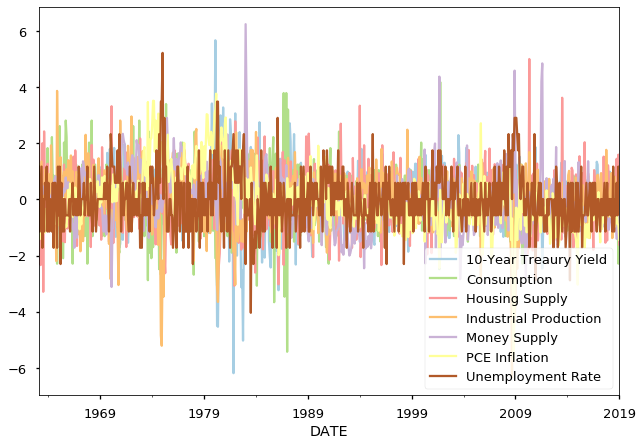

In [13]:
data.plot(colormap=mpl.cm.get_cmap('Paired'))

In [14]:
data.describe()

10-Year Treaury Yield   Consumption  Housing Supply  \
count           6.720000e+02  6.720000e+02    6.720000e+02   
mean            5.286776e-18  5.286776e-18   -1.718202e-17   
std             1.000745e+00  1.000745e+00    1.000745e+00   
min            -6.188729e+00 -5.424955e+00   -3.289553e+00   
25%            -5.220823e-01 -5.220961e-01   -5.981461e-01   
50%             5.866094e-03  6.624696e-02   -5.962785e-03   
75%             5.338145e-01  6.545900e-01    5.969917e-01   
max             5.672513e+00  4.184648e+00    5.004822e+00   

       Industrial Production  Money Supply  PCE Inflation  Unemployment Rate  
count           6.720000e+02  6.720000e+02     672.000000       6.720000e+02  
mean           -1.586033e-17 -4.229421e-17       0.000000      -5.286776e-18  
std             1.000745e+00  1.000745e+00       1.000745       1.000745e+00  
min            -6.343674e+00 -3.116768e+00      -5.708025      -4.036297e+00  
25%            -5.072022e-01 -6.088000e-01      -0.585006      -5.640655e-01  
50%             5.989761e-02 -6.087366e-02      -0.154797       1.463987e-02  
75%             5.843039e-01  5.262085e-01       0.471039       5.933452e-01  
max             3.868550e+00  6.245793e+00       3.770232       5.222988e+00

In [15]:
time_dim = data.shape[0]
regressor_dim = data.shape[1] + int(include_mean)
regressand_dim = data.shape[1]

## Estimation

In [16]:
stick_scale = 5
# mean and standard deviation
beta_mu = 0 * np.eye(regressor_dim,regressand_dim, k=-1)
beta_sigma = .25 * np.eye(regressor_dim, regressor_dim) 
beta_df = 5
comp_cov_mu1 = 3
comp_cov_mu2 = 3
# comp_std_mean = .25
# comp_cov_mean = comp_std_mean**2 * np.ones(regressand_dim)


In [17]:
beta = pd.DataFrame(beta_mu)
beta.columns=list(data.columns)
beta.index = ['Intercept'] + list(data.columns)
beta.loc['Money Supply','Money Supply'] = .99
beta.loc['PCE Inflation','PCE Inflation'] = .99
# beta.loc['Fed Funds Rate','Fe d Funds Rate'] = .99
beta.loc['10-Year Treaury Yield','10-Year Treaury Yield'] = 0
beta.loc['Unemployment Rate', 'Unemployment Rate'] = 0

In [18]:
comp_cov_mean =  .5 * ( 1 - np.diag(beta.values, k=-1)) + .005

In [19]:
comp_cov_mean

array([0.505, 0.505, 0.505, 0.505, 0.01 , 0.01 , 0.505])

In [20]:
prior = {
    'coeff': {'mean':beta.values, 'cov': beta_sigma, 'hierarchical': True, 'nu': beta_df},
    'cov':  {'scale': comp_cov_mean, 'mu1': comp_cov_mu1, 'mu2': comp_cov_mu2, 'hierarchical': True},
    'expected_cluster_dim': stick_scale,
}

In [21]:
if include_mean:
    regressor =  pd.DataFrame(add_dummy_feature(data.iloc[:-1]), index=data.index[:-1],
                             columns=['Intercept'] + list(data.columns))
else:
    regressor = data.iloc[:-1]

regressand = data.iloc[1:]

In [22]:
result_dict = cdpm.estimate_cdpm(regressor=regressor,regressand=regressand, num_draws=num_draws, 
                                 progress_bar=tqdm_notebook, prior=prior,filename=filename,
                                 data=data, clusters=5)

In [23]:
return_var_dict = cdpm.estimate_var(beta_mu=beta_mu, comp_cov=comp_cov_mean * np.eye(regressand_dim),
                                    regressor=regressor, regressand=regressand, num_draws=num_draws, 
                                    progress_bar=tqdm_notebook, prior=prior,filename=var_filename, data=data)

In [ ]:
filename